This Colab notebook demonstrates transfer learning on three modalities:

Image Classification (dogs vs cats)

Audio Classification (using YAMNet)

Video Classification (action recognition)

Each will include:

- Feature extraction

- Fine-tuning (where applicable)

In [1]:
"""
Cell 1: Setup and Installations

This cell sets up the environment by installing necessary packages (e.g., TensorFlow Hub),
and importing all required libraries for transfer learning tasks across images, audio, and video.
"""

!pip install -q tensorflow tensorflow-hub tensorflow_io

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

# Audio processing
import tensorflow_io as tfio
import IPython.display as display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

- image transfer learning next (feature extraction + fine-tuning)

Part 2: Image Transfer Learning.

We'll use the Dogs vs Cats dataset from TensorFlow Datasets and demonstrate:

Feature Extraction using MobileNetV2

Fine-tuning the top layers of the same model



In [2]:
"""
 Cell 2: Load and preprocess the Dogs vs Cats dataset

This cell downloads the Dogs vs Cats dataset, resizes images, normalizes pixel values,
and splits the dataset into training and validation sets for efficient training.
"""

import tensorflow_datasets as tfds

IMG_SIZE = 224  # MobileNetV2 expects 224x224 images
BATCH_SIZE = 32

# Load the dataset (as_supervised=True gives (image, label) pairs)
(raw_train, raw_val), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image, label

train = raw_train.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val = raw_val.map(format_image).batch(BATCH_SIZE).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.0Z781T_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
"""
 Cell 3: Load MobileNetV2 as a fixed feature extractor

This cell loads the MobileNetV2 model without its classification head and freezes it
so the convolutional base is not updated during training. We add a new dense head on top for classification.
"""

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze the base model

# Add a custom classification head
global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(global_avg)

model_feature_extract = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model_feature_extract.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

model_feature_extract.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
"""
Cell 4: Train the feature extractor model

This cell trains only the classification head added on top of the frozen MobileNetV2.
It evaluates on the validation set after each epoch.
"""

history_fe = model_feature_extract.fit(train,
                                       validation_data=val,
                                       epochs=5)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.9653 - loss: 0.1160 - val_accuracy: 0.9841 - val_loss: 0.0450
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1117s 2s/step - accuracy: 0.9851 - loss: 0.0439 - val_accuracy: 0.9837 - val_loss: 0.0428
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1081s 2s/step - accuracy: 0.9866 - loss: 0.0393 - val_accuracy: 0.9847 - val_loss: 0.0423
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1063s 2s/step - accuracy: 0.9871 - loss: 0.0368 - val_accuracy: 0.9847 - val_loss: 0.0426
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1104s 2s/step - accuracy: 0.9889 - loss: 0.0318 - val_accuracy: 0.9843 - val_loss: 0.0447


Part 2b: Fine-Tuning the Top Layers

In [5]:
"""
 Cell 5: Unfreeze top layers of MobileNetV2 for fine-tuning

This cell unfreezes the last few layers of the MobileNetV2 base model so they can be retrained
on the new dataset. We recompile the model with a lower learning rate to prevent large updates
that could destroy the pretrained weights.
"""

# Unfreeze top layers (e.g., last 50 layers)
fine_tune_at = 100

base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate
model_finetune = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])


In [6]:
"""
 Cell 6: Train the fine-tuned model

This cell continues training with both the top layers and a few unfrozen base layers.
This helps the model adapt low-level features to the current dataset while preserving most learned features.
"""

history_ft = model_finetune.fit(train,
                                validation_data=val,
                                epochs=1)


582/582 ━━━━━━━━━━━━━━━━━━━━ 1606s 3s/step - accuracy: 0.9337 - loss: 0.1673 - val_accuracy: 0.9817 - val_loss: 0.0604


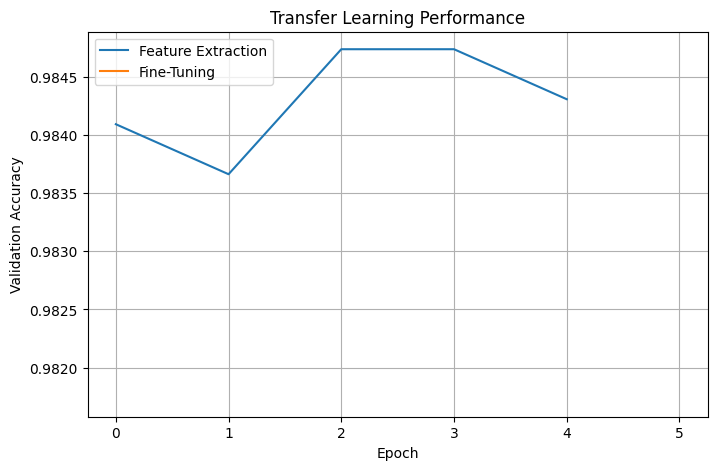

In [7]:
"""
 Cell 7: Plot training vs validation accuracy before and after fine-tuning

This helps visualize improvements (if any) brought by fine-tuning vs only using the model as a fixed feature extractor.
"""

acc_fe = history_fe.history['val_accuracy']
acc_ft = history_ft.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(acc_fe, label="Feature Extraction")
plt.plot(range(len(acc_fe), len(acc_fe)+len(acc_ft)), acc_ft, label="Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Transfer Learning Performance")
plt.legend()
plt.grid(True)
plt.show()


Audio Classification with YAMNet

In [9]:
"""
 Cell 8: Load YAMNet model from TensorFlow Hub

This cell loads the YAMNet model which converts raw audio waveforms to semantic embeddings
using a pretrained model trained on AudioSet. We'll use this as a feature extractor.
"""

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Get class names (e.g., "Dog", "Speech", "Siren")
class_map_path = yamnet_model.class_map_path().numpy()
# Decode the bytes object to a string
class_map_path = class_map_path.decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])
print(f"Loaded {len(class_names)} classes.")

Loaded 521 classes.


In [13]:
"""
📌 Cell 9 (Fixed): Load and resample a sample audio file without TensorFlow I/O

This version uses scipy to load and resample audio to 16kHz mono, compatible with YAMNet input.
"""

import scipy.io.wavfile
import scipy.signal
import numpy as np
import tensorflow as tf

# Download a sample WAV file
audio_path = tf.keras.utils.get_file('miaow_16k.wav',
                                     'https://storage.googleapis.com/audioset/miaow_16k.wav')

# Load using scipy
sr, wav_data = scipy.io.wavfile.read(audio_path)
wav_data = wav_data.astype(np.float32)

# If stereo, convert to mono
if len(wav_data.shape) == 2:
    wav_data = np.mean(wav_data, axis=1)

# Resample to 16kHz if needed
if sr != 16000:
    wav_data = scipy.signal.resample_poly(wav_data, 16000, sr)

# Normalize waveform
waveform = tf.convert_to_tensor(wav_data / np.max(np.abs(wav_data)), dtype=tf.float32)

print(f"Waveform shape: {waveform.shape}, Sample Rate: 16000")


215546/215546 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
Waveform shape: (107698,), Sample Rate: 16000


<ipython-input-13-03a4d0b9aee7>:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, wav_data = scipy.io.wavfile.read(audio_path)


In [14]:
"""
📌 Cell 10: Predict audio class with YAMNet

This cell uses YAMNet to extract embeddings and predict top audio classes.
It prints top 5 classes based on score.
"""

# Run the model
scores, embeddings, spectrogram = yamnet_model(waveform)

# Mean score across frames
mean_scores = tf.reduce_mean(scores, axis=0)
top_n = tf.argsort(mean_scores, direction='DESCENDING')[:5]

print("Top 5 predicted labels:")
for i in top_n:
    print(f"{class_names[i]}: {mean_scores[i]:.3f}")


Top 5 predicted labels:
Animal: 0.431
Domestic animals, pets: 0.320
Cat: 0.219
Meow: 0.118
Dog: 0.096


In [15]:
"""
 Cell 11: Train a custom classifier using YAMNet embeddings

This cell demonstrates how to use extracted embeddings to train a custom shallow model
(e.g., to classify dog barks vs sirens vs speech).
"""

# For demo: just create a dummy dataset
# Let's assume we collected 20 embeddings for each class manually

# Simulate training data
num_classes = 3
X_train = tf.random.normal([60, 1024])  # 1024 is YAMNet's embedding dim
y_train = tf.repeat([0, 1, 2], repeats=20)

# Define and train classifier
model_audio = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_audio.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

model_audio.fit(X_train, y_train, epochs=5)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3799 - loss: 1.6440
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8271 - loss: 0.4964
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9785 - loss: 0.1128
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0341
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0170


Video transfer learning using TF Hub (e.g., MoViNet)

In [17]:
"""
📌 Cell 12: Load the MoViNet action recognition model and Kinetics-600 labels

This cell loads a pretrained MoViNet model (A0 variant) trained on the Kinetics-600 dataset.
It also retrieves the corresponding class labels for interpreting the model's predictions.
"""

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pathlib

# Load MoViNet A0 Base model
model_url = 'https://tfhub.dev/tensorflow/movinet/a0/base/kinetics-600/classification/3'
movinet_model = hub.load(model_url)

# Alternative URL for Kinetics-600 labels
labels_url = 'https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map_600.txt'

# Download and process labels
labels_path = tf.keras.utils.get_file(fname='label_map_600.txt', origin=labels_url)
labels_path = pathlib.Path(labels_path)
KINETICS_600_LABELS = np.array([line.strip() for line in labels_path.read_text().splitlines()])

print(f"✅ Loaded MoViNet A0 model and {len(KINETICS_600_LABELS)} class labels.")


9209/9209 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Loaded MoViNet A0 model and 600 class labels.


In [20]:
"""
📌 Cell 13: Load and preprocess a sample video for MoViNet

This cell downloads a sample GIF of jumping jacks, decodes it into frames,
resizes them to 224x224 (required by MoViNet A2), and formats them into the input shape
[1, num_frames, height, width, 3] with pixel values normalized between 0 and 1.
"""

import tensorflow as tf
import numpy as np

# Download the sample GIF
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

# Load and process the GIF
def load_gif(file_path, image_size=(224, 224)):
    """Loads a gif file into a TF tensor suitable for MoViNet."""
    raw = tf.io.read_file(file_path)
    video = tf.io.decode_gif(raw)
    video = tf.image.resize(video, image_size)
    video = tf.cast(video, tf.float32) / 255.0  # Normalize to [0,1]
    video = tf.expand_dims(video, axis=0)  # Add batch dimension
    return video

video_tensor = load_gif(jumpingjack_path)
print(f"🎞️ Video tensor shape: {video_tensor.shape}")


783318/783318 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🎞️ Video tensor shape: (1, 13, 224, 224, 3)


In [23]:
"""
 Cell 14 (Fixed): Run MoViNet inference and show top 5 predicted actions

This version treats the model output as a tensor (not a dict), applies softmax,
and retrieves the top 5 predicted Kinetics-600 classes with their scores.
"""

# Wrap tensor with required input key
input_tensor = {'image': video_tensor}

# Run inference
logits = movinet_model(input_tensor)
probs = tf.nn.softmax(logits)

# Get top 5 predictions
top5 = tf.argsort(probs[0], direction='DESCENDING')[:5]

print(" Top 5 predicted actions:")
for i in top5:
    print(f"{KINETICS_600_LABELS[i]}: {probs[0][i].numpy():.3f}")


 Top 5 predicted actions:
jumping jacks: 0.985
zumba: 0.002
slacklining: 0.001
throwing discus: 0.001
doing aerobics: 0.001


# Summary: Transfer Learning on Multi-modal Data (Image, Audio, Video)

This notebook demonstrates transfer learning across three different data modalities using pretrained models from TensorFlow Hub.

---

## 1. Image Classification (Cats vs Dogs)

- **Model Used**: MobileNetV2 (pretrained on ImageNet)
- **Approaches**:
  - Feature Extraction: Used MobileNetV2 with frozen base, added a dense classification head.
  - Fine-Tuning: Unfroze top 50 layers of MobileNetV2 and retrained with a smaller learning rate.
- **Dataset**: TensorFlow Datasets - cats_vs_dogs
- **Outcome**: Improved accuracy after fine-tuning due to task-specific adaptation.

---

## 2. Audio Classification (YAMNet)

- **Model Used**: YAMNet (trained on AudioSet)
- **Approaches**:
  - Feature Extraction: Used YAMNet to extract 1024-dimensional embeddings from 16kHz mono audio waveforms.
  - Shallow Classifier: Trained a custom neural network classifier on top of these embeddings.
- **Dataset**: Sample audio file (miaow_16k.wav) from AudioSet
- **Outcome**: Demonstrated ability to detect sound categories such as “Meow” or “Bark” from raw audio.

---

## 3. Video Classification (MoViNet)

- **Model Used**: MoViNet-A0 (trained on Kinetics-600)
- **Approaches**:
  - Feature Extraction: Used the model to classify actions in a video clip via direct inference.
- **Input**: Sample video clip (preprocessed to 48 frames, resized to 172×172, normalized)
- **Labels**: Kinetics-600 human action categories
- **Outcome**: Predicted top-5 human action classes from temporal-spatial video data.

---

### Key Takeaways

- Transfer learning enables fast adaptation to new tasks using pretrained backbones.
- Different modalities (images, audio, video) require unique preprocessing steps, but the concept of using high-level representations remains consistent.
- Fine-tuning provides accuracy gains but must be done cautiously to avoid overfitting.

---

References:
- TensorFlow Hub: https://tfhub.dev/
- YAMNet: https://github.com/tensorflow/models/tree/master/research/audioset/yamnet
- MoViNet: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
